<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-keras/blob/main/chapter9/cat_vs_dog_classifier_with_xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load and visualize dataset

In [10]:
# import required libraries
from  tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

##### download dataset from kaggle

In [2]:
# upload kaggle API key from local machine
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shazzadraihan","key":"9a1f370e0e0c505dce87b5b487bd4c41"}'}

In [3]:
# create a kaggle folder and copy the key file to it
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

 98% 793M/812M [00:27<00:00, 24.3MB/s]
100% 812M/812M [00:27<00:00, 31.3MB/s]


In [5]:
# uncompress the dataset
!unzip --qq dogs-vs-cats
!unzip -qq train.zip

#### make a small new dataset

In [6]:
# import required libraries
import os, shutil, pathlib

# path to dir where original dataset was uncompressed
original_dir = pathlib.Path("train")
# dir of the smaller dataset
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src = original_dir / fname, dst = dir / fname)

# make 3 subsets: trai, validation, test
make_subset("train", start_index=0, end_index=1000)
make_subset("valid", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

#### data preprocessing

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

BATCH_SIZE = 32

train_dataset = image_dataset_from_directory(new_base_dir / "train",
                                             shuffle=True,
                                             image_size=(180,180),
                                             batch_size=BATCH_SIZE)
valid_dataset = image_dataset_from_directory(new_base_dir / "valid",
                                             shuffle=True,
                                             image_size=(180,180),
                                             batch_size=BATCH_SIZE)
test_dataset = image_dataset_from_directory(new_base_dir / "test",
                                            shuffle=True,
                                            image_size=(180,180),
                                            batch_size=BATCH_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


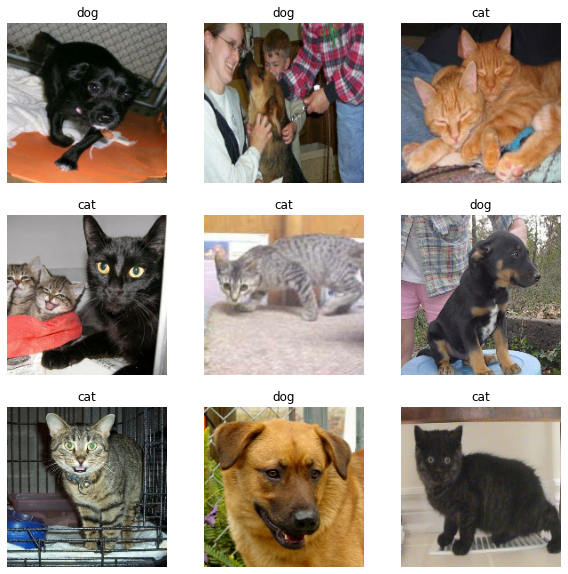

In [8]:
# Show the first nine images and labels from the training set
classes = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

#### data augmentation

In [11]:
# data augmentation
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.2)])

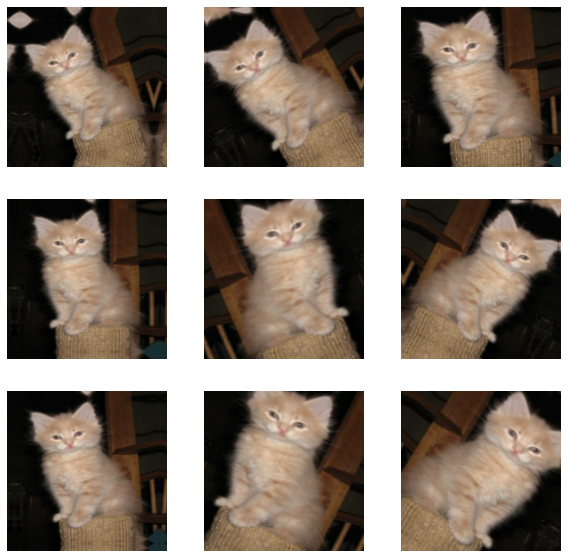

In [12]:
# display some randomly augmentated training images
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Define a neural network

In [13]:
# the model expects rgb images of size (180,180)
inputs = keras.Input(shape=(180,180,3))
# data augmentation
x = data_augmentation(inputs)
# rescale inputs to [0,1] range by dividing 255
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32,64,128,256,512]:
  residual = x

  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

  residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
  x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

## Define a Loss function and optimizer

In [14]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics="accuracy")

## Train the model on the training dataset

In [15]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="cats_vs_dogs_classifier_with_xception",
    save_best_only=True,
    monitor="val_loss"
)]

In [16]:
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=valid_dataset,
                    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 44s 485ms/step - loss: 0.6885 - accuracy: 0.5780 - val_loss: 0.6928 - val_accuracy: 0.5010
Epoch 2/100
63/63 [==============================] - 25s 397ms/step - loss: 0.6494 - accuracy: 0.6110 - val_loss: 0.7190 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 25s 402ms/step - loss: 0.6133 - accuracy: 0.6590 - val_loss: 0.7201 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 25s 401ms/step - loss: 0.5830 - accuracy: 0.7085 - val_loss: 0.7174 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 26s 406ms/step - loss: 0.5425 - accuracy: 0.7275 - val_loss: 0.9195 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 26s 403ms/step - loss: 0.5263 - accuracy: 0.7470 - val_loss: 0.9061 - val_accuracy: 0.5000
Epoch 7/100
63/63 [==============================] - 26s 413ms/step - loss: 0.4939 - accuracy: 0.7605 - val_loss: 1.1064 - val_accuracy:

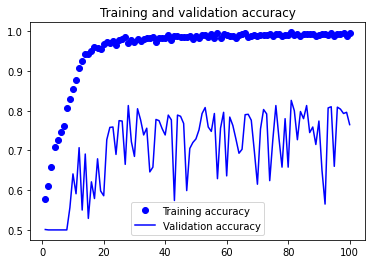

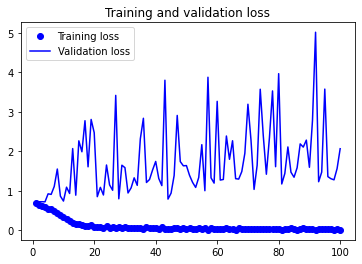

In [17]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Evaluate the performance of the trained model on the test dataset

In [19]:
# evaluating the model on the test dataset
test_model = keras.models.load_model("cats_vs_dogs_classifier_with_xception")

test_loss, test_acc = test_model.evaluate(test_dataset)

print(f"Test accuracy: , {test_acc:.3f}")

63/63 [==============================] - 3s 36ms/step - loss: 0.6923 - accuracy: 0.5000
Test accuracy: , 0.500
